# Compare logistic regression models of several mutations for a) covariates only and b) covariates with gene expression data to determine marginal gain using gene expression data 

In [1]:
import os
import urllib
import random
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, Imputer, FunctionTransformer
from sklearn.feature_selection import SelectKBest
from statsmodels.robust.scale import mad
from IPython.display import display
import gc

In [2]:
%matplotlib inline
plt.style.use('seaborn-notebook')

## Load Data

In [3]:
%%time
path = os.path.join('..', '..', 'download', 'covariates.tsv')
covariates = pd.read_table(path, index_col=0)

CPU times: user 80.8 ms, sys: 16.3 ms, total: 97.1 ms
Wall time: 179 ms


In [31]:
# Filter covariates dataset to obviate need for imputation.
valid_cols = [col for col in covariates.columns.values if 
              (('acronym' in col) or ('male' in col) or ('n_mutations') in col)]
covariates = covariates[valid_cols]
covariates.head()

,acronym_ACC,acronym_BLCA,acronym_BRCA,acronym_CESC,acronym_CHOL,acronym_COAD,acronym_DLBC,acronym_ESCA,acronym_GBM,acronym_HNSC,...,acronym_STAD,acronym_TGCT,acronym_THCA,acronym_THYM,acronym_UCEC,acronym_UCS,acronym_UVM,female,male,n_mutations_log1p
sample_id,,,,,,,,,,,,,,,,,,,,,
TCGA-02-0047-01,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,3.6889
TCGA-02-0055-01,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,3.5264
TCGA-02-2483-01,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,3.2189
TCGA-02-2485-01,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,3.6889
TCGA-02-2486-01,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,3.6889


In [4]:
%%time
path = os.path.join('..', '..', 'download', 'expression-matrix.tsv.bz2')
expression = pd.read_table(path, index_col=0)

CPU times: user 3min 14s, sys: 4.37 s, total: 3min 18s
Wall time: 3min 19s


In [12]:
%%time
path = os.path.join('..','..','download', 'mutation-matrix.tsv.bz2')
Y = pd.read_table(path, index_col=0)

CPU times: user 1min 59s, sys: 8.86 s, total: 2min 7s
Wall time: 2min 10s


In [32]:
X = {}
X['model a'] = covariates
X['model b'] = pd.concat([covariates,expression], axis=1)
for k in ['model a','model b']:
    print(X[k].shape)

NameError: name 'expression' is not defined

In [7]:
mutations = {
    '7157': 'TP53',   # tumor protein p53
    '238': 'ALK',     # anaplastic lymphoma receptor tyrosine kinase
}

## Define pipeline and Cross validation model fitting

In [8]:
# Parameter Sweep for Hyperparameters

param_grid = {
    'classify__loss': ['log'],
    'classify__penalty': ['elasticnet'],
    'classify__alpha': 10.0 ** np.linspace(-3, 1, 10),
    'classify__l1_ratio': [0.15],
}

pipeline = Pipeline(steps=[
    ('standardize', StandardScaler()),
    ('classify', SGDClassifier(random_state=0, class_weight='balanced'))
])

In [9]:
cv_pipeline = {}
cv_pipeline['model a'] = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='roc_auc')
cv_pipeline['model b'] = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='roc_auc')

## Functions to get statistics for a given model 

In [34]:
# Get statistics for a given model. 

def get_aurocs(X, y, pipeline, series, model_type):
    """
    Fit the classifier for the given mutation (y) and output predictions for it
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=0)
    pipeline.fit(X=X_train, y=y_train)
    y_pred_train = pipeline.decision_function(X_train)
    y_pred_test = pipeline.decision_function(X_test)
    cv_score_df = grid_scores_to_df(pipeline.grid_scores_)
    coeff_df = get_coeffs(pipeline, X_train, model_type)
    n_pos, n_neg = get_sign_coeffs(coeff_df)
    cov_ranks = get_ranks_covariates_feat(coeff_df)
    print(y_pred_train)
    series['mean_cv_auroc'] = cv_score_df.score.max()
    series['training_auroc'] = roc_auc_score(y_train, y_pred_train)
    series['testing_auroc'] = roc_auc_score(y_test, y_pred_test)
    series['n_pos_coeffs'] = n_pos
    series['n_neg_coeffs'] = n_neg
    series['n_positive_mutation'] = sum(y==1)
    series['n_negative_mutation'] = sum(y==0)
    series['cum_rank_cov_feat'] = cov_ranks.sum()
    series['median_rank_cov_feat'] = np.median(cov_ranks)
    series['mean_rank_cov_feat'] = np.mean(cov_ranks)
    return series

def grid_scores_to_df(grid_scores):
    """
    Convert a sklearn.grid_search.GridSearchCV.grid_scores_ attribute to 
    a tidy pandas DataFrame where each row is a hyperparameter-fold combinatination.
    """
    rows = list()
    for grid_score in grid_scores:
        for fold, score in enumerate(grid_score.cv_validation_scores):
            row = grid_score.parameters.copy()
            row['fold'] = fold
            row['score'] = score
            rows.append(row)
    df = pd.DataFrame(rows)
    return df

def get_coeffs(pipeline, X_train, model_type):
    """
    Get a dataframe with the training coefficients 
    """
    final_pipeline = pipeline.best_estimator_
    final_classifier = final_pipeline.named_steps['classify']
    
    # Get indices of features
    if model_type == 'model a': 
        select_indices = list(range(len(covariates.columns.values)))
    else:
        select_indices = final_pipeline.named_steps['features'].transform(
            np.arange(len(X_train.columns)).reshape(1, -1)
        ).tolist()
        select_indices = [x for sublist in select_indices for x in sublist]
    
    # Make df features, weights
    coef_df = pd.DataFrame.from_items([
        ('feature', X_train.columns[select_indices]),
        ('weight', final_classifier.coef_[0]),
    ])

    return coef_df

def get_sign_coeffs(coef_df):
    return (coef_df.weight>0).sum(), (coef_df.weight<0).sum()

def get_ranks_covariates_feat(coef_df):
    coef_df['abs'] = coef_df['weight'].abs()
    coef_df = coef_df.sort_values('abs', ascending=False)
    
    def RepresentsInt(s):
        try: 
            int(s)
            return True
        except ValueError:
            return False

    coef_df['is_cov_feat'] = [not RepresentsInt(x) for x in coef_df['feature']]
    ranks = np.flatnonzero(coef_df['is_cov_feat'])
    return ranks

auroc_dfs = {}

## Train the models.

In [35]:
%%time
# Train model a: covariates only.
warnings.filterwarnings("ignore") # ignore deprecation warning for grid_scores_
rows = list()
for m in list(mutations):
    series = pd.Series()
    series['mutation'] = m
    series['symbol'] = mutations[m]
    rows.append(get_aurocs(X['model a'], Y[m], cv_pipeline['model a'], series, 'model a'))
auroc_dfs['model a'] = pd.DataFrame(rows)
auroc_dfs['model a'].sort_values(['symbol', 'testing_auroc'], ascending=[True, False], inplace=True)
display(auroc_dfs['model a'])

[-1.57106019  0.07799048 -2.61537388 ..., -0.09251235 -0.53096815
  0.97408774]
[ 6.70397012  6.70397012  6.70397012 ...,  6.70397012  6.70397012
  6.70397012]


,mutation,symbol,mean_cv_auroc,training_auroc,testing_auroc,n_pos_coeffs,n_neg_coeffs,n_positive_mutation,n_negative_mutation,cum_rank_cov_feat,median_rank_cov_feat,mean_rank_cov_feat
1,238,ALK,0.840648,0.500000,0.500000,0,0,138,7168,595,17.0,17.0
0,7157,TP53,0.851637,0.847962,0.842601,14,16,2587,4719,595,17.0,17.0


CPU times: user 4.13 s, sys: 61.7 ms, total: 4.19 s
Wall time: 2.17 s


In [13]:
%%time
# Train model b: covariates with gene expression data.
warnings.filterwarnings("ignore") # ignore deprecation warning for grid_scores_
rows = list()
for m in list(mutations):
    series = pd.Series()
    series['mutation'] = m
    series['symbol'] = mutations[m]
    rows.append(get_aurocs(X['model b'], Y[m], cv_pipeline['model b'], series, 'model b'))
auroc_dfs['model b'] = pd.DataFrame(rows)
auroc_dfs['model b'].sort_values(['symbol', 'testing_auroc'], ascending=[True, False], inplace=True)

CPU times: user 49min 21s, sys: 28min 48s, total: 1h 18min 10s
Wall time: 1h 19min 27s


In [32]:
auroc_dfs['model a']['model'] = 'covariates_only'
auroc_dfs['model b']['model'] = 'combined'
auroc_df = pd.concat([auroc_dfs['model a'],auroc_dfs['model b']])
auroc_df.to_csv("./auroc_df.tsv", sep="\t", float_format="%.3g", index=False)
display(auroc_df)

,mutation,symbol,mean_cv_auroc,training_auroc,testing_auroc,n_pos_coeffs,n_neg_coeffs,n_positive_mutation,n_negative_mutation,cum_rank_cov_feat,median_rank_cov_feat,mean_rank_cov_feat,model
6,238,ALK,0.840648,0.500000,0.500000,0,0,138,7168,2415,34.5,34.500000,covariates_only
3,672,BRCA1,0.859306,0.500000,0.500000,0,0,136,7170,2415,34.5,34.500000,covariates_only
1,675,BRCA2,0.872013,0.811153,0.790877,1,0,237,7069,2415,34.5,34.500000,covariates_only
5,29126,CD274,0.887013,0.870971,0.933095,3,0,19,7287,2415,34.5,34.500000,covariates_only
0,4221,MEN1,0.849791,0.804713,0.738397,4,6,57,7249,2415,34.5,34.500000,covariates_only
4,5979,RET,0.854921,0.806310,0.756233,3,0,117,7189,2415,34.5,34.500000,covariates_only
7,7157,TP53,0.851322,0.849591,0.844948,23,32,2587,4719,2415,34.5,34.500000,covariates_only
2,7428,VHL,0.990092,0.989094,0.949362,11,10,135,7171,2415,34.5,34.500000,covariates_only
6,238,ALK,0.840648,0.500000,0.500000,0,0,138,7168,94776,1387.5,1353.942857,combined
3,672,BRCA1,0.851596,0.500000,0.500000,0,0,136,7170,94776,1387.5,1353.942857,combined


In [30]:
auroc_dfs['model a'] = auroc_dfs['model a'].drop('model',axis=1)
auroc_dfs['model b'] = auroc_dfs['model b'].drop('model',axis=1)
auroc_dfs['diff_models_ab'] = auroc_dfs['model b'].loc[:,'mean_cv_auroc':]-auroc_dfs['model a'].loc[:,'mean_cv_auroc':]
auroc_dfs['diff_models_ab'][['mutation', 'symbol']] = auroc_dfs['model b'].loc[:, ['mutation', 'symbol']]
auroc_dfs['diff_models_ab']

,mean_cv_auroc,training_auroc,testing_auroc,n_pos_coeffs,n_neg_coeffs,n_positive_mutation,n_negative_mutation,cum_rank_cov_feat,median_rank_cov_feat,mean_rank_cov_feat,mutation,symbol
6,0.000000,0.000000,0.000000,0,0,0,0,92361,1353.0,1319.442857,238,ALK
3,-0.007710,0.000000,0.000000,0,0,0,0,92361,1353.0,1319.442857,672,BRCA1
1,-0.003645,0.004780,-0.003049,4,9,0,0,89813,1356.0,1283.042857,675,BRCA2
5,-0.025761,0.011476,-0.028924,0,2,0,0,89110,1354.0,1273.000000,29126,CD274
0,0.019966,0.027076,0.013592,3,3,0,0,92145,1354.0,1316.357143,4221,MEN1
4,0.000000,0.024468,0.038443,4,10,0,0,92434,1356.0,1320.485714,5979,RET
7,0.083476,0.099406,0.085576,211,123,0,0,64285,1408.0,918.357143,7157,TP53
2,-0.003536,0.005941,-0.033529,238,252,0,0,78355,1435.0,1119.357143,7428,VHL


# Covariates only vs covariates+expression model

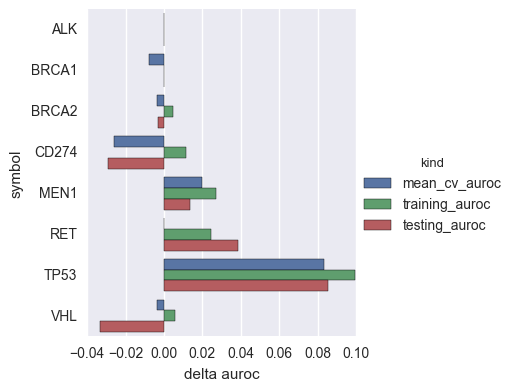

In [31]:
plot_df = pd.melt(auroc_dfs['diff_models_ab'], id_vars='symbol', value_vars=['mean_cv_auroc', 'training_auroc', 'testing_auroc'], var_name='kind', value_name='delta auroc')
grid = sns.factorplot(y='symbol', x='delta auroc', hue='kind', data=plot_df, kind="bar")